<a href="https://colab.research.google.com/github/asanneh/CS109B_Final_Project_Group_35/blob/master/Copy_of_CS109B_Final_Project_Group_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div align="center">COMPSCI 109B Final Project - Group 35</div>

# <div align="center"> Project: Measuring the Shape and Brightness of Galaxies with Neural Networks</div>

# <div align='center'> Alpha Sanneh, Brian Tao, Grace Greason, Evan Arnold</div>

## **Data Preprocessing**

In [0]:
#install libraries we need here
# !pip install tf_keras_vis
## Please NOTE: you have to install the three libraries below in order to get pymc3 working
# !pip install pymc3==3.8
# !pip install Theano==1.0.4

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os
import datetime
import h5py
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from scipy.stats import norm
import matplotlib as mpl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Change working directory to where the files needed for the project are stored
file_path = '/content/drive/My Drive/Data'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data


In [0]:
# Read data
f = h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()


In [0]:
# Get the shape of images with noise and images without noise
image_withnoise.shape, image_nonoise.shape

((18779, 64, 64), (18779, 64, 64))

## **Visualizing images**

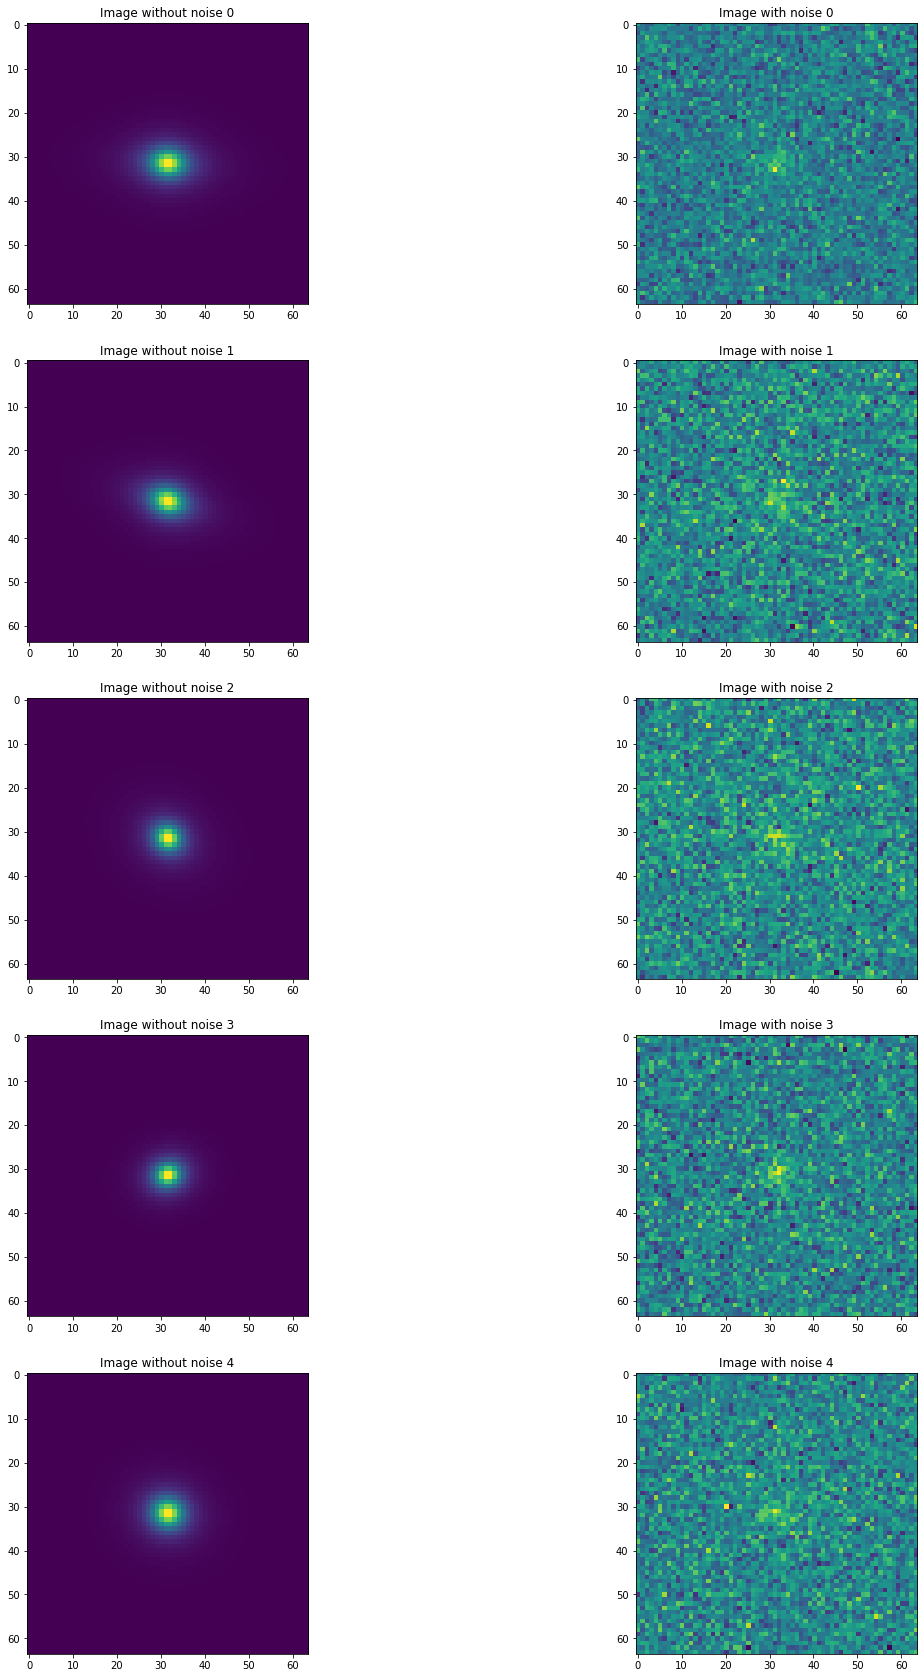

In [0]:
# Plot first five images without noise and with noise
fig, ax = plt.subplots(5,2, figsize=(20,30))
for i in range(5):
    ax[i][0].imshow(image_nonoise[i])
    ax[i][0].set_title('Image without noise {}'.format(i))
    ax[i][1].imshow(image_withnoise[i])
    ax[i][1].set_title('Image with noise {}'.format(i))

## **Inspecting noise** 

Below we plot the histogram of the noise of the dataset along with the best fit normal distribution. We do so to verify that the noise is indeed Gaussian. This will inform our model design. Specifically, it will allow us to model the noise in order to better predict the response.

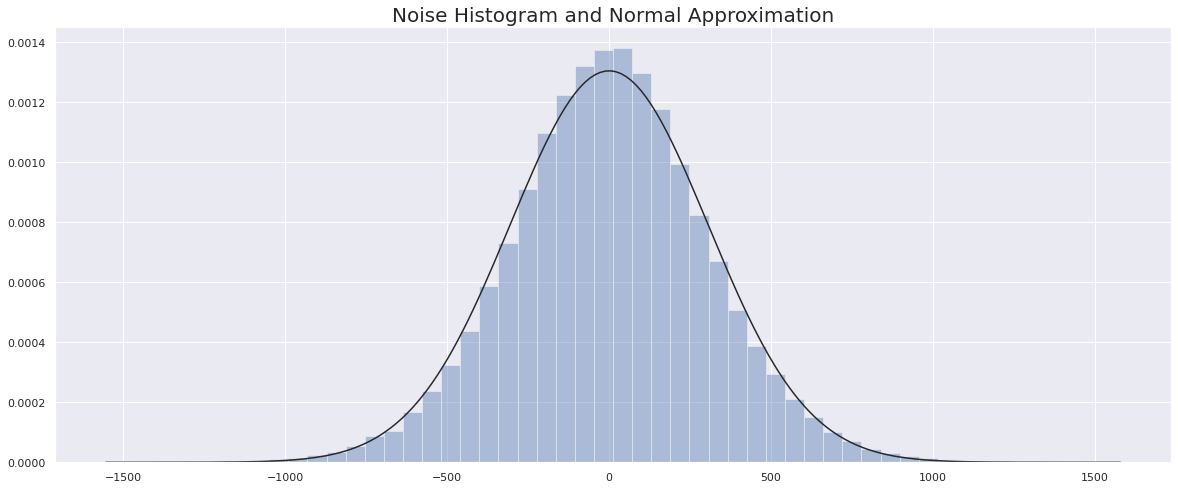

In [0]:

# distribution of noise (first n pixels for efficiency)
sns.set()
n = 100000
# noise
noise = image_withnoise - image_nonoise
noise = noise.reshape(-1, 1)
# plot
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(noise[1:n], fit=norm, kde=False, ax=ax)
ax.set_title('Noise Histogram and Normal Approximation', fontsize=20);

## **Inspecting the Correlations of the Label Parameters**

As shown below, the response variables have no significant correlation aside from g1 and g2. We expect the scatters of circles as both g1 and g2 are functions of the same variables using different sinusoid functions (cos vs. sin). Care should be taken when modeling g1 and g2 as their outcome is highly correlated (though in a non-linear fashion).

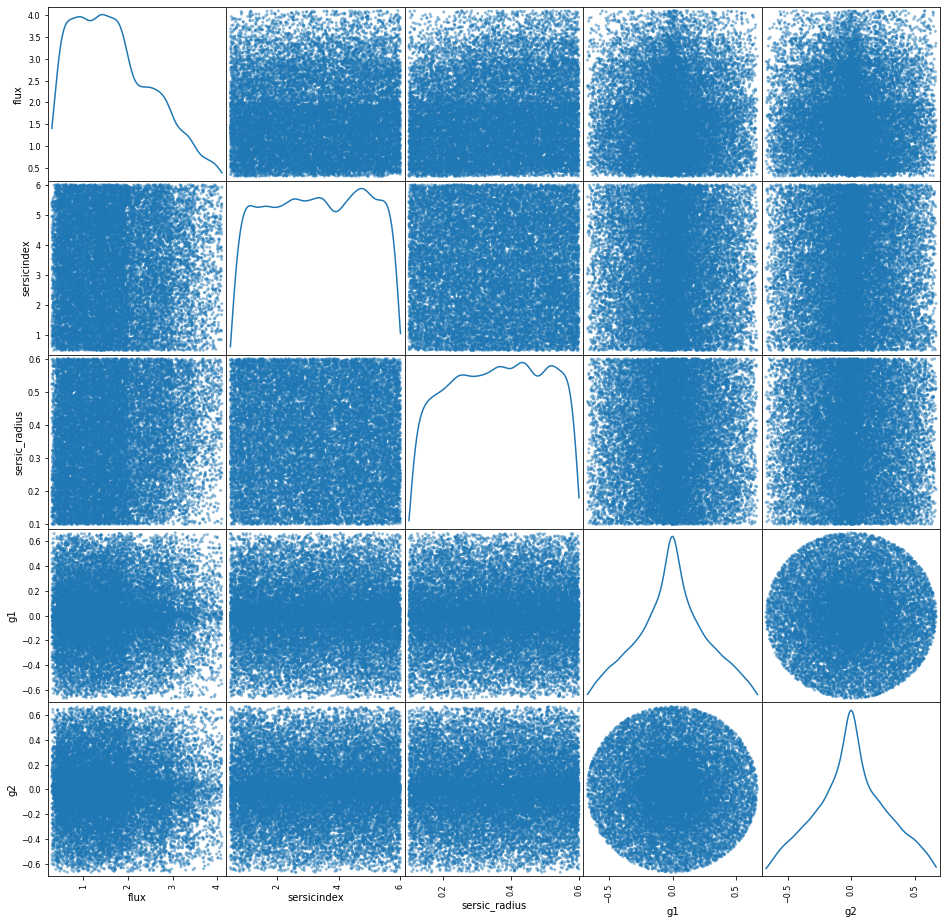

In [0]:
# convert response 2D array to labeled dataframe
label_df = pd.DataFrame(label, columns=['flux', 'sersic' 'index', 'sersic_radius', 'g1', 'g2'])
# scatter matrix of response
pd.plotting.scatter_matrix(label_df, figsize=(16, 16), diagonal='kde');

In [0]:
print(f'Image with noise max: {image_withnoise[0].max()}')
print(f'Image with noise min: {image_withnoise[0].min()}')
print(f'Image with no noise max: {image_nonoise[0].max()}')
print(f'Image with no noise min: {image_nonoise[0].min()}')

Image with noise max: 1088.6094996083598
Image with noise min: -799.6288667294024
Image with no noise max: 455.3077087402344
Image with no noise min: 0.03963421285152435


## **Inspecting the Distributions of the Label Parameters**

We expect Sérsic index and Sérsic radius to be uniformly distributed because they are each randomly generated from a uniform distribution. 

g1 and g2 have the same distribution (and are therefore highly correlated) because they are calcuated using the same mathematical function.


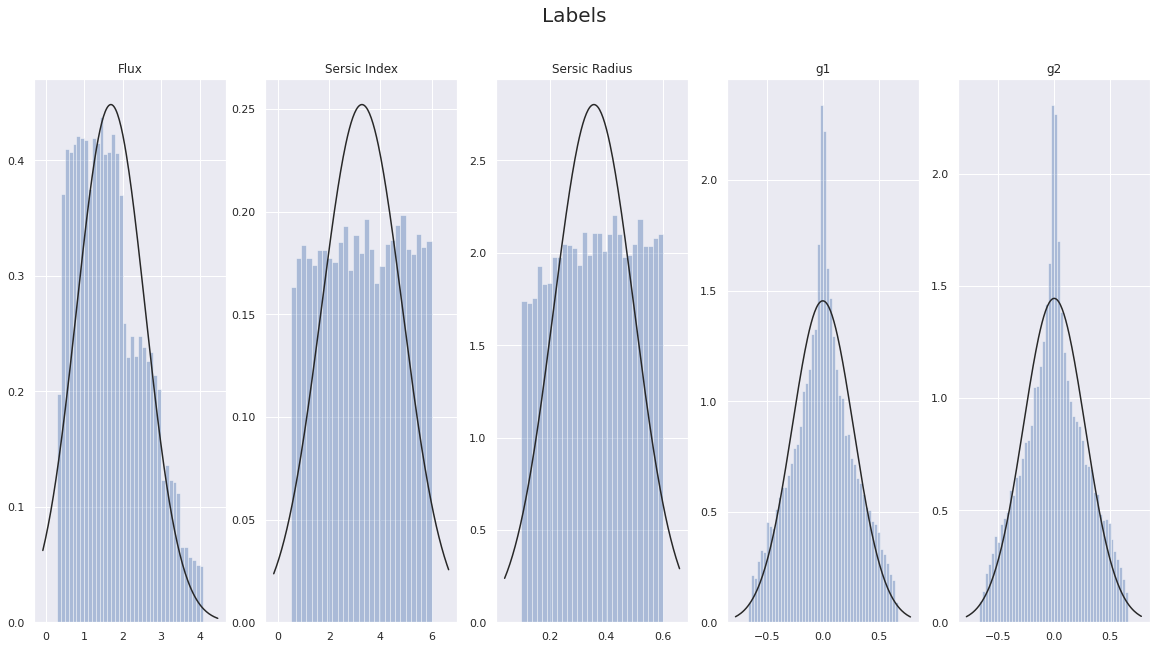

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels', fontsize=20)

sns.distplot(label[:, 0], fit=norm, kde=False,  ax=ax[0]).set_title('Flux')
sns.distplot(label[:, 1], fit=norm, kde=False,  ax=ax[1]).set_title('Sersic Index')
sns.distplot(label[:, 2], fit=norm, kde=False, ax=ax[2]).set_title('Sersic Radius')
sns.distplot(label[:, 3], fit=norm, kde=False, ax=ax[3]).set_title('g1')
sns.distplot(label[:, 4], fit=norm, kde=False, ax=ax[4]).set_title('g2')
plt.show()

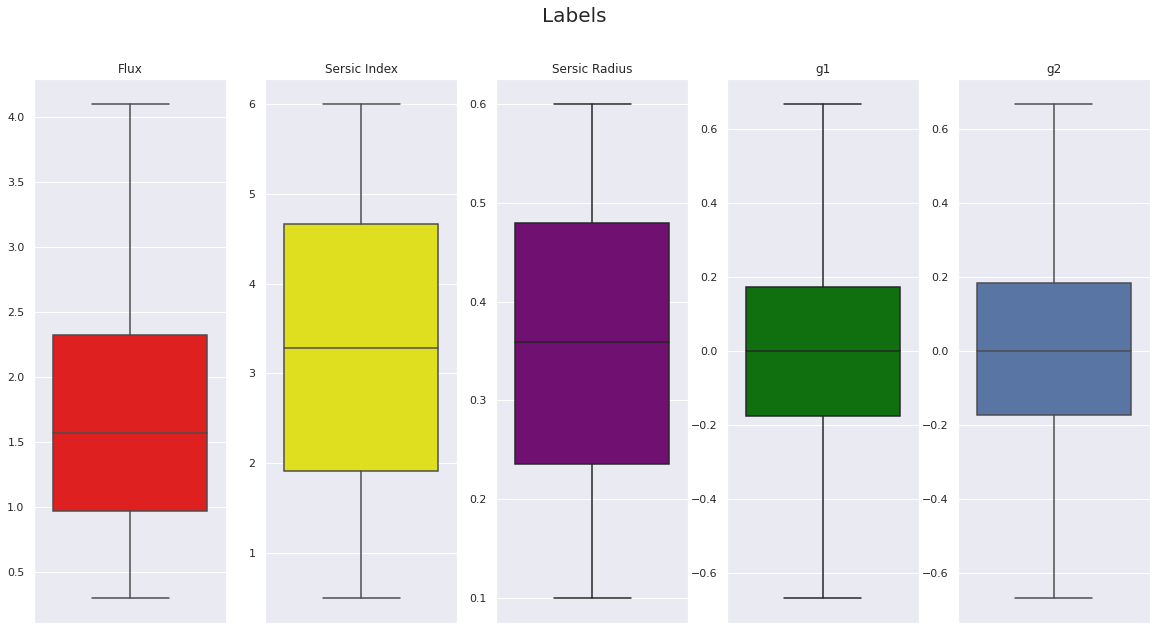

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels')

fig.suptitle('Labels', fontsize=20)
sns.boxplot(label[:, 0],  ax=ax[0], orient='v', color='red').set_title('Flux')
sns.boxplot(label[:, 1],  ax=ax[1], orient='v', color='yellow').set_title('Sersic Index')
sns.boxplot(label[:, 2],  ax=ax[2], orient='v', color='purple').set_title('Sersic Radius')
sns.boxplot(label[:, 3],  ax=ax[3],orient='v', color='green').set_title('g1')
sns.boxplot(label[:, 4],  ax=ax[4], orient='v').set_title('g2')
plt.show()


## **Inspecting Signal-to-Noise Ratio and Sigma**

Next, we plot the distribution of the signal to noise ratio of the galaxies. The code to simulate a galaxy removes all galaxies with ratios less than 10 or greater than 100, which is evident from the distribution.

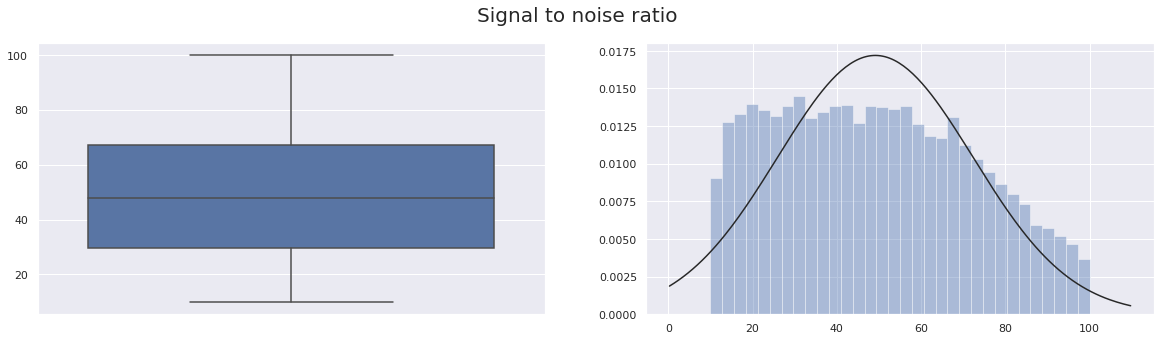

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Signal to noise ratio', fontsize=20);

sns.boxplot(snr, ax=ax[0], orient='v');
sns.distplot(snr, fit=norm, kde=False, ax=ax[1])
plt.show()


Below is the distribution for sigma, which was used to construct the noise map for each galaxy. As expected, sigma has a uniform distribution.

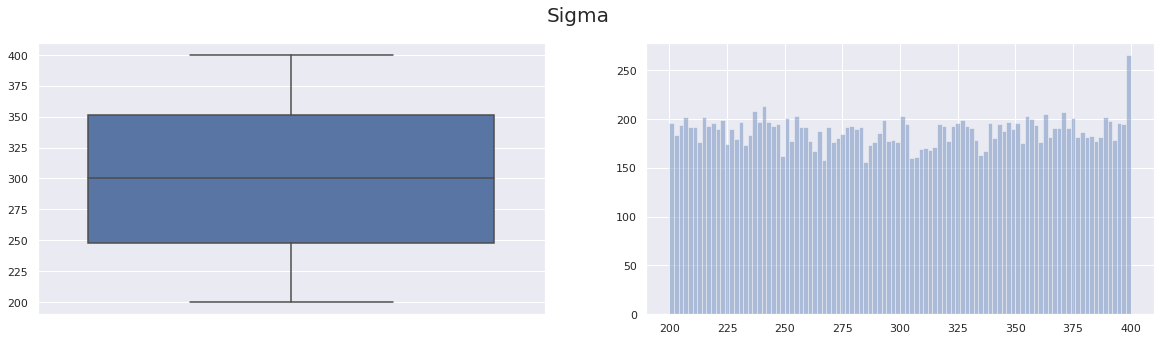

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Sigma', fontsize=20);

sns.boxplot(sigma, ax=ax[0], orient='v');
sns.distplot(sigma, kde=False, bins=100, ax=ax[1])
plt.show()

## **Key Questions**

**Given everything you have learned, if you faced this data set in the wild, how would you proceed?**

Unfortunately, "noiseless" images of galaxies like the ones we plotted above don't really exist -- signal noise is inherent to the process of taking pictures of objects millions of miles away! If we want to discern key information about the galaxies in our universe -- like flux or Sérsic index --  we must find a way to learn these parameters from the so-called "noisy" images.

We can use supervised learning to create a model that learns the essence of the data -- the actual galaxies. When fed an unfamiliar noisy image, a strong model will ignore the noise and output the galaxy's true parameters.

**What are the important measures?**

The parameters we seek to determine are flux, Sérsic index, Sérsic radius, g1, and g2. We are given images of galaxies that contain stochastic noise at every pixel, and we must train a model that essentially ignores this noise and uses only the actual galaxy to return the previously mentioned parameters.

**What are the right questions to ask, and how can the data answer them?**

We seek to learn the parameters of each galaxy, despite stochastic noise that makes this no easy task. So we ask, is it possible to accurately determine the parameters of a "noisy" galaxy? We can use a data set of noisy galaxies and their known parameters to train a model via supervised learning. Then we can simulate additional noisy galaxies and test our model's ability to accurately find their parameters. If the model performs well on the test set, we know that it has succeeded in ignoring irrelevant information. This finding has important repercussions for astronomers -- it may not be necessary to improve technology to reduce noise in images if we can glean all the information that we need from a noisy image.


## **Model Building and Performance Analysis**

We have generated a new dataset for modeling. This dataset has flux, g1, and g2 fixed. Noise and PSF are fixed.

We will use regression and parametric modeling with Markov Chain Monte Carlo (MCMC) as baseline models

In [0]:
#building a baseline model to compare against Deep Convolutional Neural Networks from our newly generated data
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Set new file path to access generated dataset
file_path = '/content/drive/My Drive/Data/Data_flux_radius'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data/Data_flux_radius


In [0]:
# Import our generated dataset
image_no_noise = pd.read_pickle('img_no_noise_flux_radius.pkl')
image_with_noise = pd.read_pickle('img_with_noise_flux_radius.pkl')
labels = pd.read_pickle('labels_flux_radius.pkl')
snr = pd.read_pickle('snr_flux_radius.pkl')

In [6]:
print(f'Shape of image_no_noise: {image_no_noise.shape}')
print(f'Shape of image_with_noise: {image_with_noise.shape}')
print(f'Shape of labels: {labels.shape}')

Shape of image_no_noise: (10000, 64, 64)
Shape of image_with_noise: (10000, 64, 64)
Shape of labels: (10000, 5)


In [7]:
# Observe that Sersic index, g1, and g2 are fixed
labels[0:5]

array([[ 3.08978209,  3.        ,  0.449856  , -0.0694    ,  0.1515    ],
       [ 3.11185202,  3.        ,  0.83842206, -0.0694    ,  0.1515    ],
       [ 0.98337073,  3.        ,  0.65187262, -0.0694    ,  0.1515    ],
       [ 0.45967895,  3.        ,  0.82260607, -0.0694    ,  0.1515    ],
       [ 3.69849803,  3.        ,  1.13474852, -0.0694    ,  0.1515    ]])

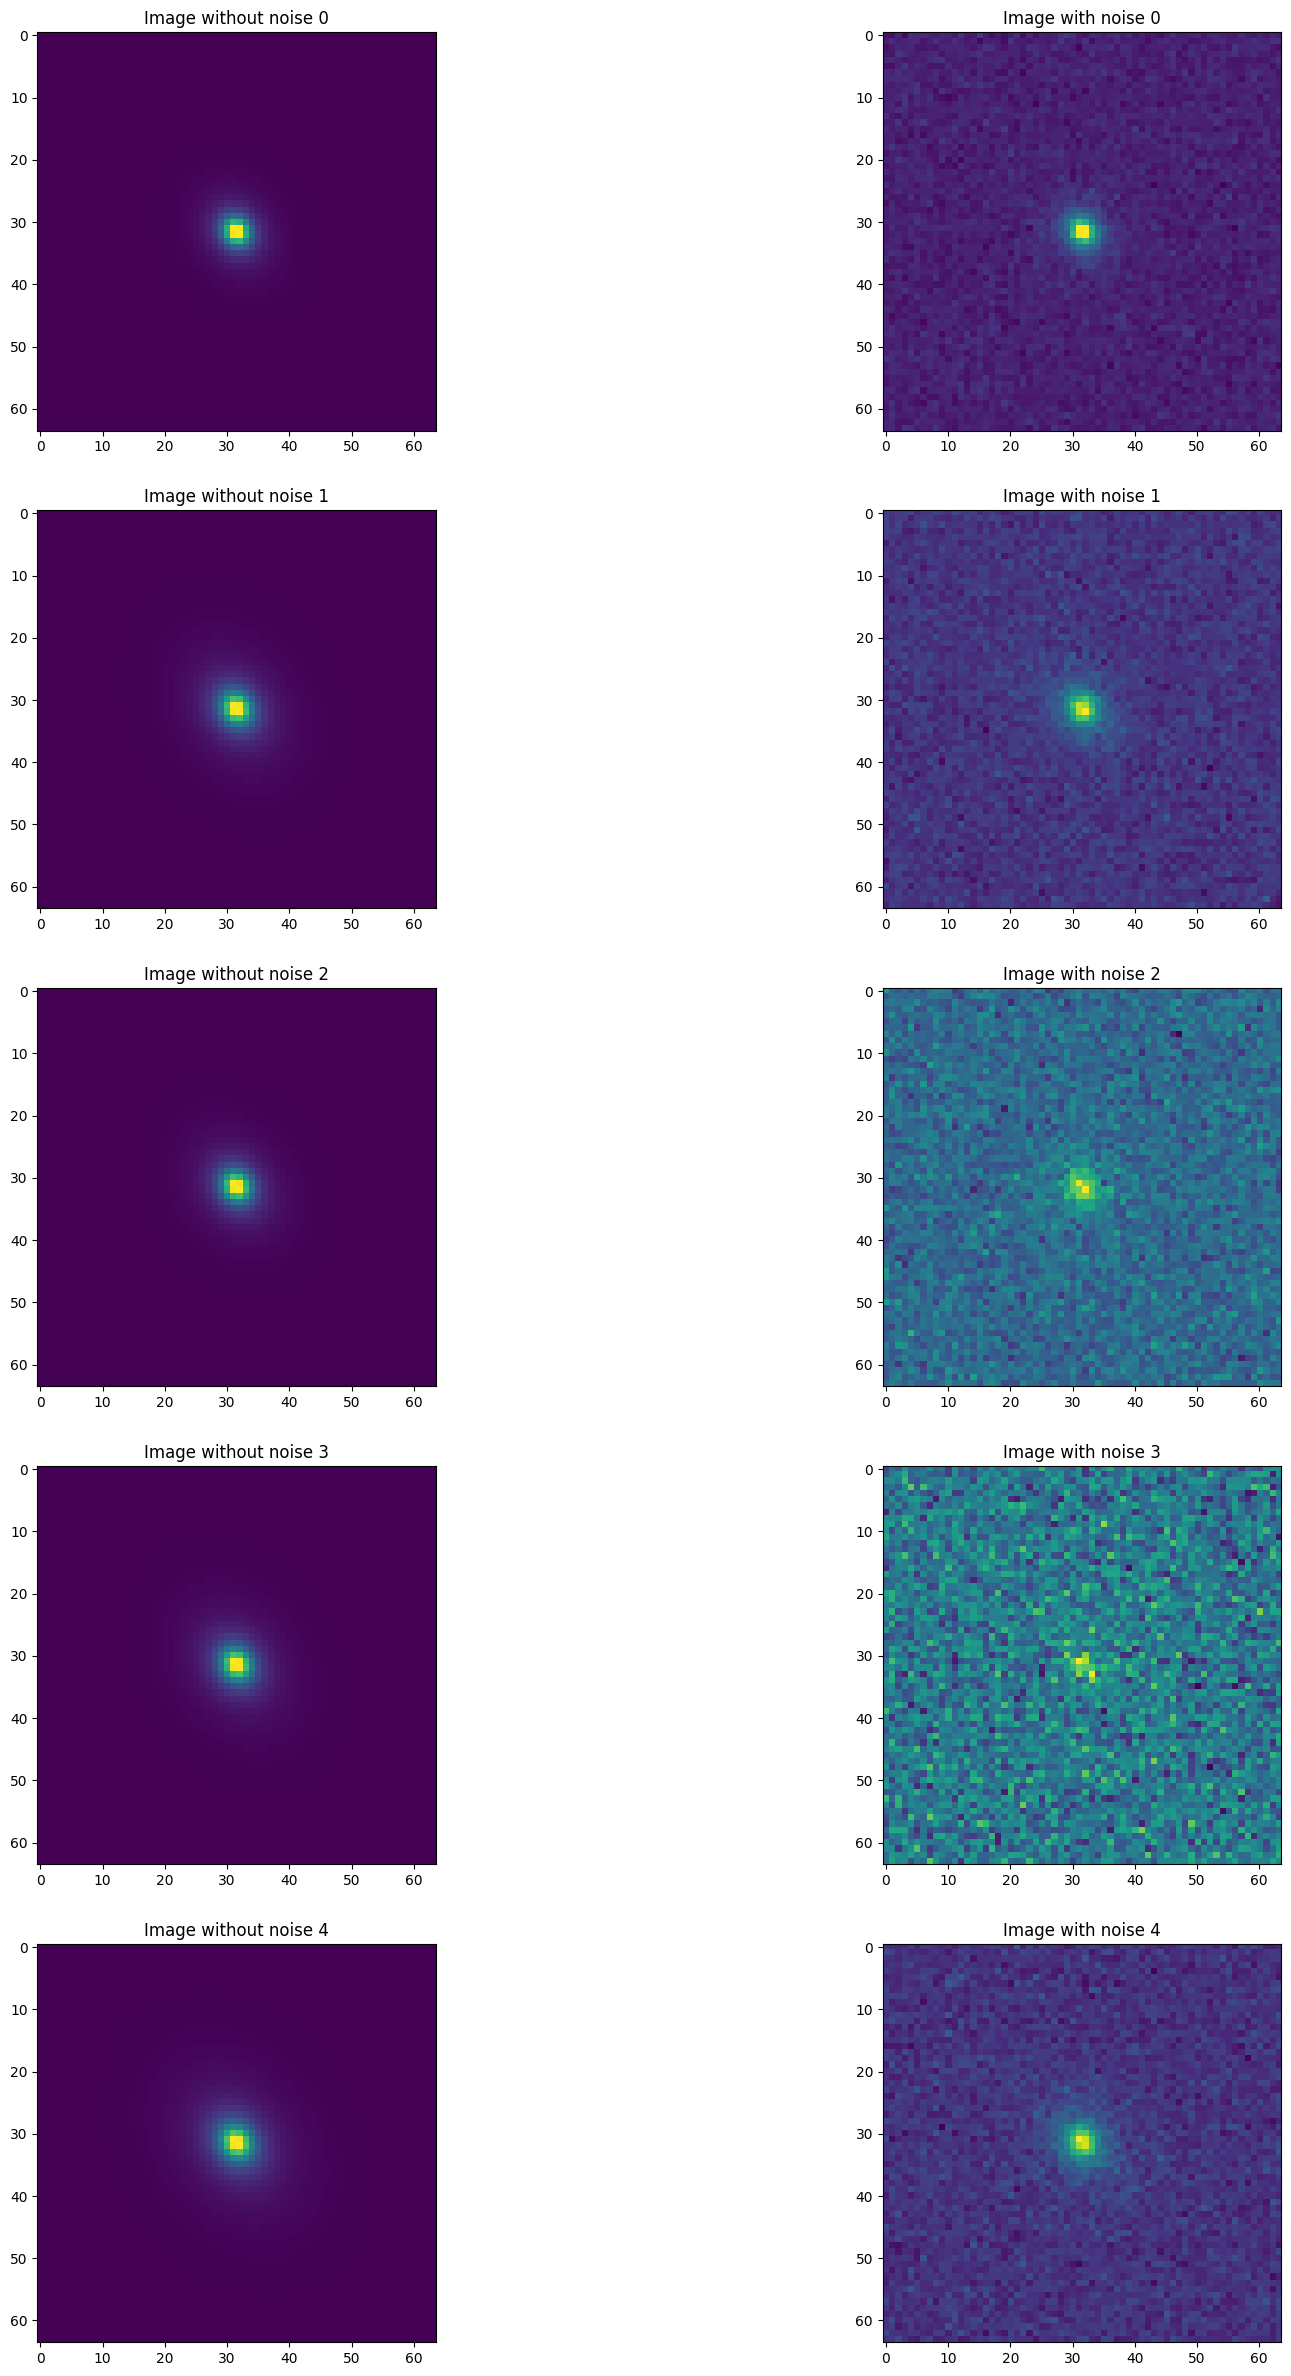

In [8]:
mpl.style.use('default')
fig, ax = plt.subplots(5,2, figsize=(20,30))
for i in range(5):
    ax[i][0].imshow(image_no_noise[i])
    ax[i][0].set_title('Image without noise {}'.format(i))
    ax[i][1].imshow(image_with_noise[i])
    ax[i][1].set_title('Image with noise {}'.format(i))

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in 

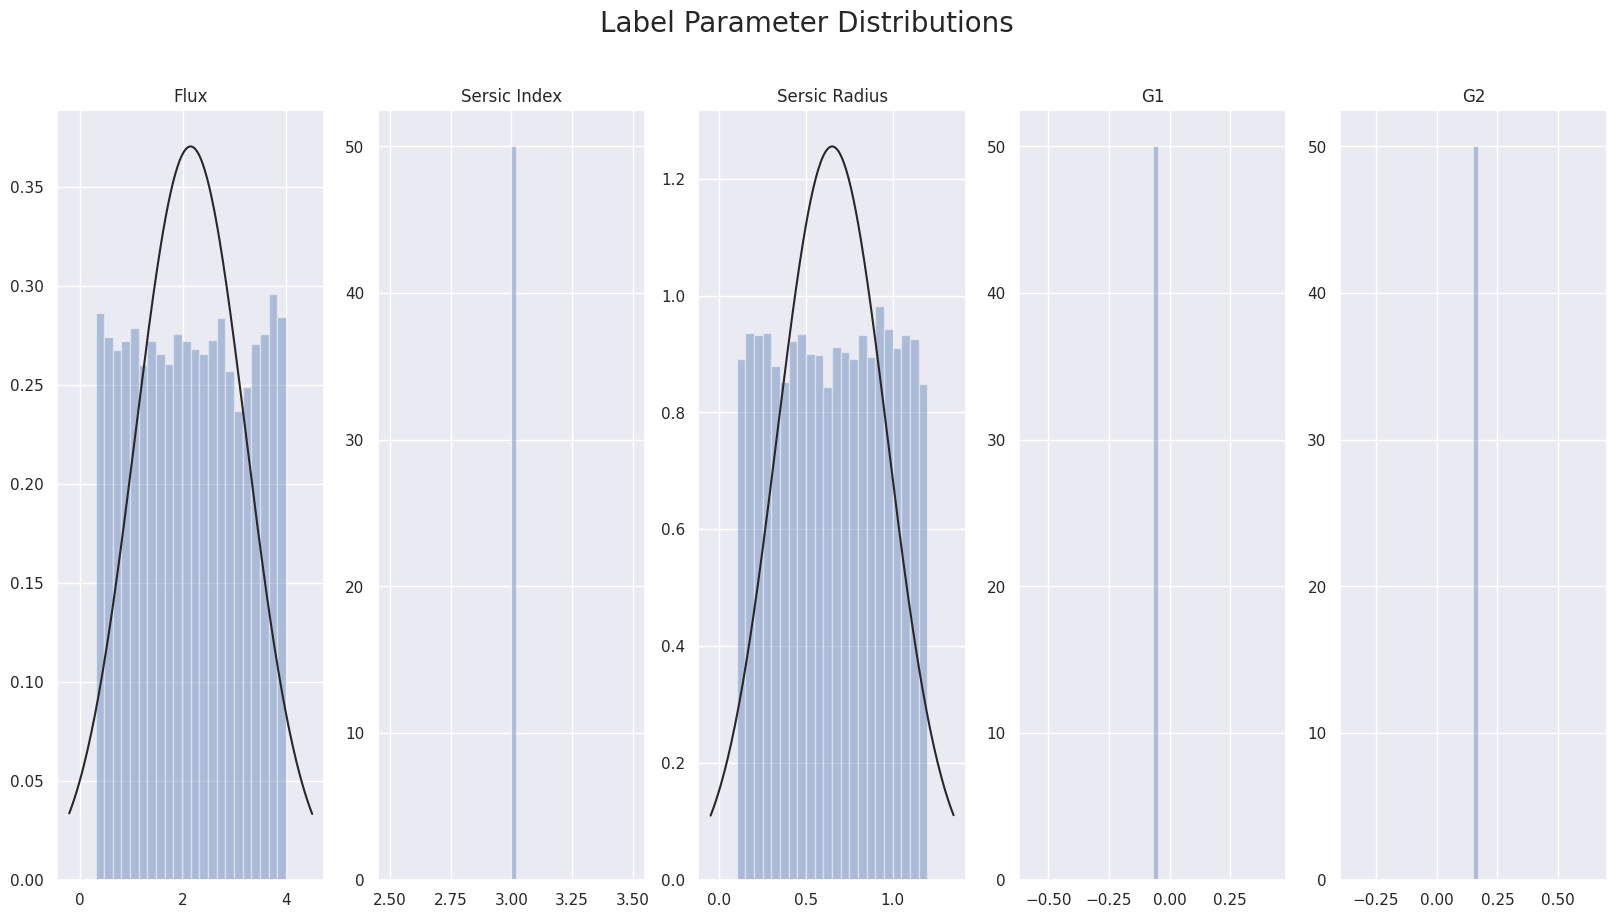

In [9]:
sns.set()
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Label Parameter Distributions', fontsize=20)

sns.distplot(labels[:, 0], fit=norm, kde=False,  ax=ax[0]).set_title('Flux')
sns.distplot(labels[:, 1], fit=norm, kde=False,  ax=ax[1]).set_title('Sersic Index')
sns.distplot(labels[:, 2], fit=norm, kde=False,  ax=ax[2]).set_title('Sersic Radius')
sns.distplot(labels[:, 3], fit=norm, kde=False,  ax=ax[3]).set_title('G1')
sns.distplot(labels[:, 4], fit=norm, kde=False,  ax=ax[4]).set_title('G2')
plt.show()

## **Baseline Models**

### Linear Regression

In [0]:
#train test split
#regresssion model is doing better when the test size is bigger
#Once the dataset increases to 10k we should see better improvement
X_train, X_test, y_train, y_test = train_test_split(
 image_with_noise, labels, test_size=0.20,   random_state=109)

In [11]:
print(f'Shape of X_train {X_train.shape}')
print(f'Shape of X_test {X_test.shape}')
print(f'Shape of y_train {y_train.shape}')
print(f'Shape of y_test {y_test.shape}')

Shape of X_train (8000, 64, 64)
Shape of X_test (2000, 64, 64)
Shape of y_train (8000, 5)
Shape of y_test (2000, 5)


In [12]:
%%time
#Using RidgeCV Model with L2 penalty to fit X_train
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:, [0,2]])

CPU times: user 2min 54s, sys: 14.4 s, total: 3min 8s
Wall time: 1min 39s


In [13]:
print(f'Traning Score is: {clf.score(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:, [0,2]])*100:.2f}')
print(f'Testing Score is: {clf.score(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]), y_test[:, [0,2]])*100:.2f}')

Traning Score is: 98.48
Testing Score is: 93.60


In [0]:
y_pred = clf.predict(X_test.reshape(-1, X_test.shape[1]* X_test.shape[2]))

In [15]:
print(f' R2 Score is: {r2_score(y_test[:, [0,2]], y_pred)*100.0:2f}')

 R2 Score is: 72.329213


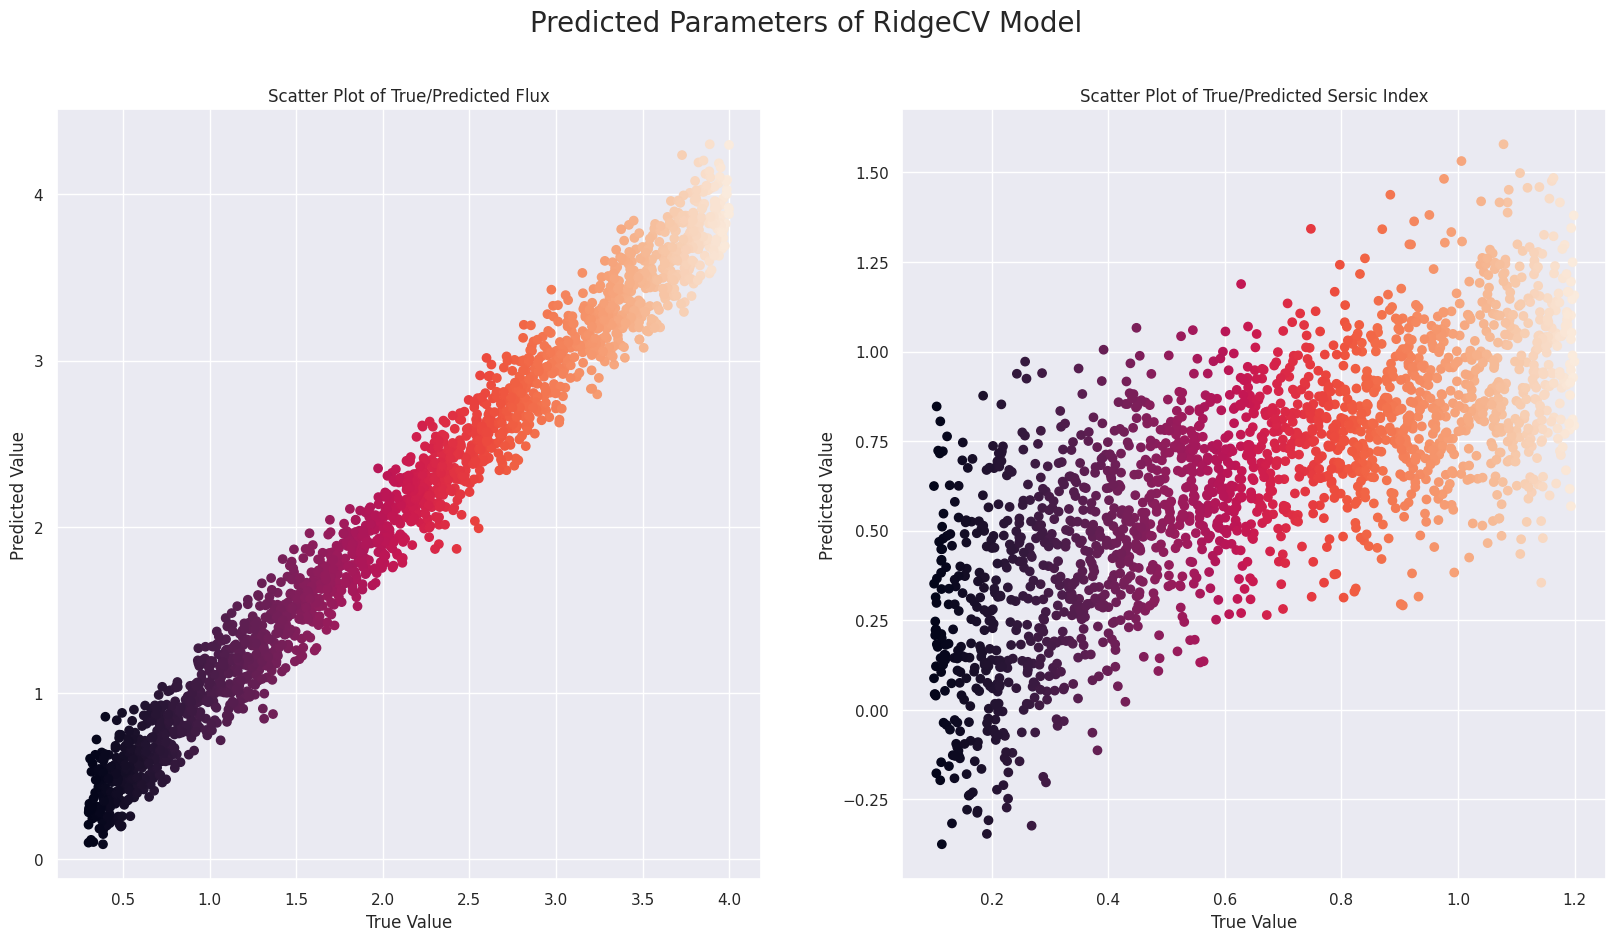

In [16]:
#plot predicted parameter distributions
# mpl.style.use('default')
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('Predicted Parameters of RidgeCV Model', fontsize=20)

x_ax = np.random.randint(0,len(y_test), size=(len(y_test),1))

ax[0].scatter(y_test[:, [0]], y_pred[:, [0]], c=[y_test[:, [0]]])
ax[0].set_title('Scatter Plot of True/Predicted Flux')
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')


ax[1].scatter(y_test[:, [2]], y_pred[:, [1]], c=[y_test[:, [2]]])
ax[1].set_title('Scatter Plot of True/Predicted Sersic Index')
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')


plt.show();

### Model Fitting

Here we use a parametric generative model for the galaxy that outputs an image of a galaxy as a function of the sersic radius and flux. We then use PyMC3's implementation of **Markov Chain Monte Carlo** to estimate the parameters.
We implement and test the generative model proposed by Regier, McAuliffe, and Prabhat (2015). Their model is defined as follows: let $z$ be a low-dimensional latent random vector. Given $z$, we model the observed intensities of the image’s $m$ pixels $\mathbf{x} = (x_1, x_2, \dots, x_m)$ as

$$
\mathbf{x}|z \sim \mathrm{MVN}\left(f_{\mu}(z), f_{\Sigma}(z)\right).
$$

In the above formulation, $f_{\mu}$ and $f_{\Sigma}$ are deterministic functions which return a vector of $m$ means and an $m \times m$ covariance matrix. In our case, $z$ is the vector of flux and sersic radius, $m = 64^2$, and we assume no covariance among pixels. The original paper presumes these functions to be neural networks which share some weights. To this end, we use a variation of a variational auto-encoder. The encoder takes sersic radius and flux as inputs and outputs a latent space equal to a mean vector and covariance matrix of the specified dimensions. The decoder simply generates a single draw (image with no noise) from the multivariate normal distribution given by the latent space.  

We model the priors of sersic radius and flux as normal with mean and standard deviation given by their sample estimates. The prior for noise is a multivarite normal distribution with constant mean $0$, constant standard devaition $300$, and no covariance. Drawn samples of sersic radius and flux are first passed through the encoder to return the mean vector and covariance matrix. Noise is added to the covariance matrix.  

Source: Prabhat, Mr & Regier, Jeffrey & McAuliffe, Jon. (2015). A deep generative model for astronomical images of galaxies. 

In [0]:
# pymc3
import pymc3 as pm

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, Input, Dense
from tensorflow.keras.optimizers import Adam

# theano (for PyMC3 compatability)
import theano.tensor as tt
from theano.compile.ops import as_op

In [0]:
# train and test sets (images have NO noise)
X_train_para, X_test_para, y_train_para, y_test_para = train_test_split(image_no_noise, labels, 
                                                                        test_size=0.20,   
                                                                        random_state=109)

In [0]:
# extract variable labels from y_train
y_train_para = y_train_para[:,[0,2]]
y_test_para = y_test_para[:,[0,2]]

In [0]:
class Sampling(Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        batch = tf.keras.backend.shape(z_mean)[0]
        dim = tf.keras.backend.int_shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [0]:
# input constants
np.random.seed(4)
tf.random.set_seed(3)
input_shape = (2,)
n_pixels = 64 ** 2

# encoder 
inputs = Input(shape=input_shape, name='sersic_profile')
dense1 = Dense(64, activation='relu', name='dense1')(inputs)
dense2 = Dense(128, activation='relu', name='dense2')(dense1)
dense3 = Dense(256, activation='relu', name='dense3')(dense2)
dense4 = Dense(512, activation='relu', name='dense4')(dense3)

# mean and log-variance of each pixel
z_mean = Dense(n_pixels, activation='linear', name='mean')(dense4)
z_log_var = Dense(n_pixels, activation='linear', name='log_var')(dense4)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# decoder
pixels = Input(shape=(n_pixels,), name='z_sampling')
reshape = Reshape((64, 64))(pixels)
decoder = Model(pixels, reshape, name='decoder')
 
# auto-encoder
outputs = decoder(encoder(inputs)[2])
AE = Model(inputs, outputs, name='AE')

# compile and summary
AE.compile(optimizer='adam', loss='mse')
#AE.summary()

In [0]:
# fit model
%%time
AE_history = AE.fit(y_train_para, X_train_para, batch_size=64, epochs=20, 
                    validation_data=(y_test_para, X_test_para), shuffle=True, verbose=0)

CPU times: user 9.6 s, sys: 803 ms, total: 10.4 s
Wall time: 7.98 s


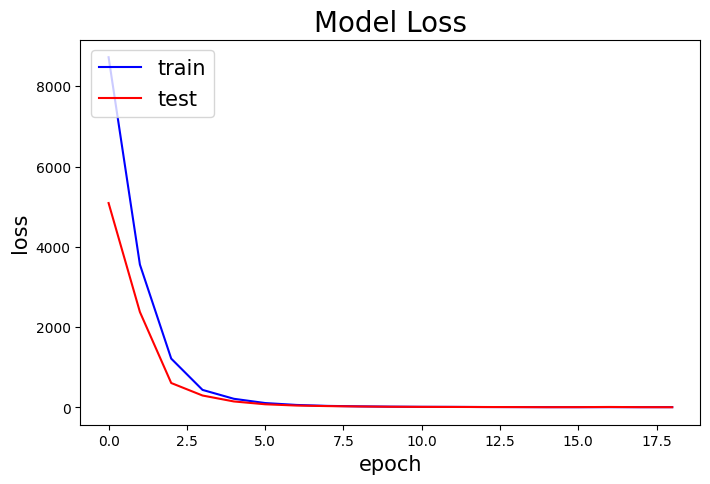

In [0]:
# model train and test loss
plt.figure(figsize=(8,5))
plt.plot(AE_history.history['loss'][1:], c='blue')
plt.plot(AE_history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

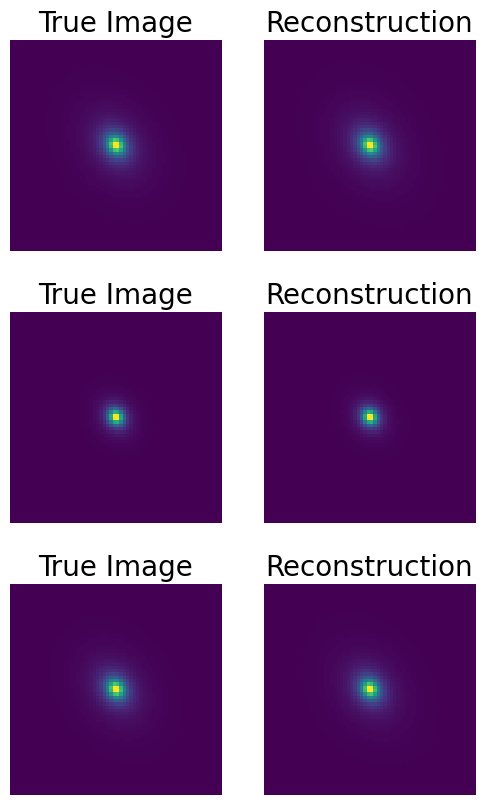

In [0]:
# auto-encoder results
n_results = 3
fig, ax = plt.subplots(n_results, 2, figsize=(6,10))
mpl.style.use('default')

# random images
image_indices = np.random.randint(low=0, high=y_train_para.shape[0]-1, size=n_results)

for i in range(n_results):
  # true image
  ax[i][0].imshow(X_train_para[i].reshape(64, 64))
  ax[i][0].set_title('True Image' + str(), fontsize=20)
  ax[i][0].axis('off')
  ax[i][0].grid(False)

  # decoder prediction
  ax[i][1].imshow(AE.predict(y_train_para[i].reshape(1, 2))[0])
  ax[i][1].set_title('Reconstruction', fontsize=20)
  ax[i][1].axis('off')
  ax[i][1].grid(False)

In [0]:
# wrap encoder in theano function for compatability with PyMC3
@as_op(itypes=[tt.dscalar] * 2, otypes=[tt.dvector, tt.dmatrix])
def mean_covariance(flux, radius):

  # Sersic profile
  profile = np.array([flux, radius]).reshape(1, 2)

  # mean and variance of each pixel
  mu, cov, _ = encoder.predict(profile)
  mu = mu[0]
  cov = np.diag(cov[0])

  return mu.astype(np.float64), cov.astype(np.float64)

In [0]:
# prior parameters
flux_mean = y_train_para[:,0].mean()
flux_std = y_train_para[:,0].std()
radius_mean = y_train_para[:,1].mean()
radius_std = y_train_para[:,1].std()
noise_std = 300

In [0]:
# turn off log of sampler progress
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

In [0]:
# constants
def param_model_predictions(image, n_samples):
  """Returns MCMC estimates for sersic radius and flux"""
  with pm.Model() as parametric_model:

    # Sersic profile
    flux = pm.Normal('flux', mu=flux_mean, sd=flux_std)
    radius = pm.Normal('sersic_radius', mu=radius_mean, sd=radius_std)

    # parameters of pixels in image 
    mu, cov = mean_covariance(flux, radius)

    # include noise
    cov = pm.Deterministic('noise', cov + np.diag(np.full(n_pixels, 10)))

    # distribution of pixels in image with noise
    image = pm.MvNormal('pixels', mu=mu, cov=cov, shape=n_pixels, observed=image.flatten())

    # trace
    step = pm.Metropolis([flux, radius])
    trace = pm.sample(n_samples, tune=0, step=step, progressbar=False, 
                      compute_convergence_checks=False)

  return np.mean(trace['flux']), np.mean(trace['sersic_radius'])

In [0]:
# select subset of test set to predict
%%time
n_samples = 30
para_indices = np.random.randint(y_test_para.shape[0] - 1, size=n_samples)

# get model predictions for test set
model_preds = np.empty((para_indices.shape[0], 2))
for i, image in enumerate(X_test[para_indices]):
  flux, radius = param_model_predictions(image, 1)
  model_preds[i,0] = flux
  model_preds[i,1] = radius 

# results
model_mse = ((y_test_para[para_indices] - model_preds)**2).mean().round(3)
print('Parametric Model MSE:', model_mse)

Parametric Model MSE: 0.675
CPU times: user 7min 15s, sys: 3.75 s, total: 7min 19s
Wall time: 7min 18s


**Limitations of Method:** PyMC3 cannot efficiently sample from models which include arbitrary deterministic functions. In our case, we require an arbitrary deterministic function (the auto-encoder). Thus, computational contraints severly limit the potential of this model -- we can only perform a minimal number of samples for each image, and therefore the results are very close to the mean of the prior. 

**Conclusion:** This baseline model better highlights the challenges of traditional methodologies than provide meaningful baseline predictions. 

## **Convolutional Neural Networks (CNNs)**

We fit our convolutional network to three versions of data that we generated.  The first version is used to predict flux and Sérsic radius with the other parameters held constant (Sérsic index = 3, g1 = -0.0694, g2 = 0.1515) and noise and PSF held constant (300 and 0.5, respectively).  The second version is the same as the first except noise (200,400) and PSF (0.5, 1) are allowed to vary.  The third version is used to predict all the labels, but noise and PSF are held constant again.

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, optimizers

In [0]:
# Split data into train and test sets
indices = np.linspace(0, 9999, 10000, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise, labels, indices, test_size=0.2)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

Below is the model architecture for the CNNs we will make.

In [0]:
# Function to create CNN
def create_model(num_param): 
    
    

    # Create sequential model
    model = Sequential(name='CNN_Model') 
    input_shape = (64, 64, 1)

    # Add network layers
    model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu',  input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding = 'same', strides = (2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(1, (3, 3), padding = 'same', strides = (2,2), activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_param, activation='linear'))

    model.summary()
    
    return model

### CNN #1: Predicting flux and Sérsic radius with the other parameters, noise, and PSF held constant.


In [0]:
# Create model
CNN = create_model(num_param=2)

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 512)       11

In [0]:
# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            verbose=1)]

# Compile model
CNN.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

In [0]:
# Set hyperparameters
batch_size = 32
epochs = 50

# Train model
history = CNN.fit(X_train, y_train[:, [0,2]], batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test[:, [0,2]]), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
250/250 [==============================] - 42s 167ms/step - loss: 1.6794 - mean_absolute_error: 0.1797 - val_loss: 1.5286 - val_mean_absolute_error: 0.2337
Epoch 2/50
250/250 [==============================] - 40s 159ms/step - loss: 1.2605 - mean_absolute_error: 0.1272 - val_loss: 1.1557 - val_mean_absolute_error: 0.1664
Epoch 3/50
250/250 [==============================] - 40s 159ms/step - loss: 0.9930 - mean_absolute_error: 0.1152 - val_loss: 0.8973 - val_mean_absolute_error: 0.1188
Epoch 4/50
250/250 [==============================] - 40s 159ms/step - loss: 0.8037 - mean_absolute_error: 0.1025 - val_loss: 0.7250 - val_mean_absolute_error: 0.0931
Epoch 5/50
250/250 [==============================] - 40s 158ms/step - loss: 0.6878 - mean_absolute_error: 0.1103 - val_loss: 0.6079 - val_mean_absolute_error: 0.0792
Epoch 6/50
250/250 [==============================] - 40s 159ms/step - loss: 0.5863 - mean_absolute_error: 0.0971 - val_loss: 0.5326 - val_mean_absolute_error: 0.079

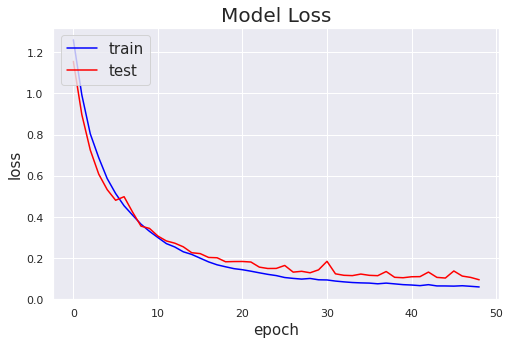

In [0]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

In [0]:
print('\n# Evaluate on test data')
results = CNN.evaluate(X_test, y_test[:, [0,2]], batch_size=128)
print('test loss, test acc:', results)


# Evaluate on test data
16/16 [==============================] - 4s 277ms/step - loss: 0.0943 - mean_absolute_error: 0.0653
test loss, test acc: [0.09431634843349457, 0.06528598070144653]



Next we plot the predicted values of the parameters (flux and Sérsic radius) against their actual values.




In [0]:
# Generate predictions using test data
CNN_predictions = CNN.predict(X_test)

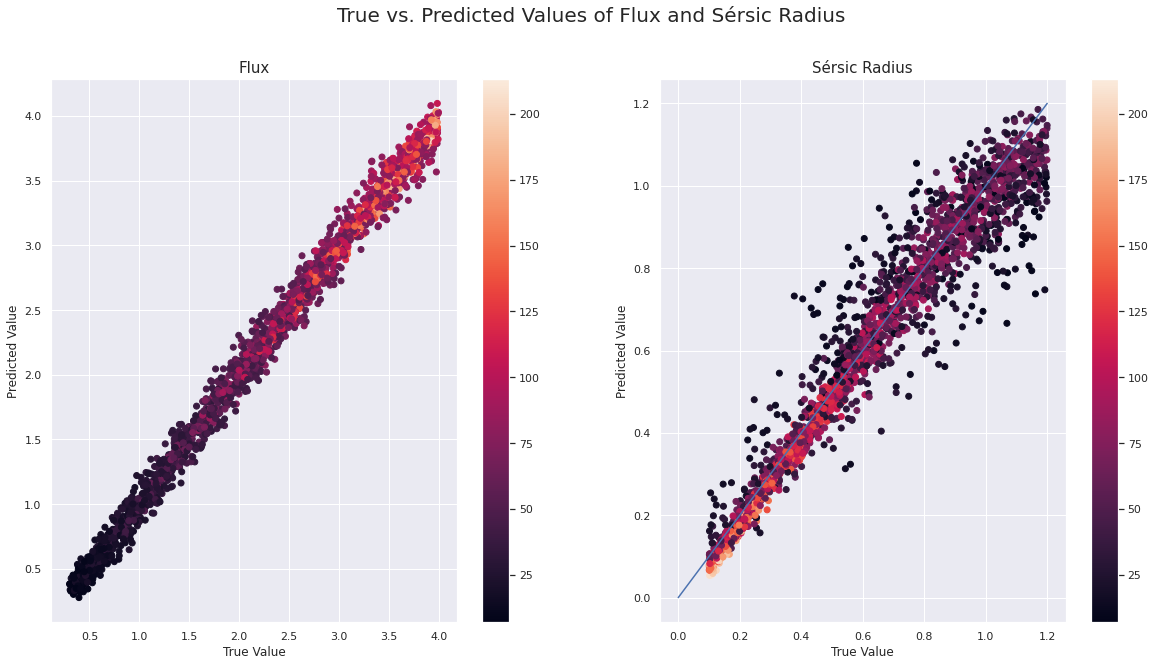

In [0]:
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('True vs. Predicted Values of Flux and Sérsic Radius', fontsize=20)

# Plot true vs. predicted values of flux
im_flux = ax[0].scatter(y_test[:, [0]], CNN_predictions[:, 0], c=[snr[indices_test]])
ax[0].set_title('Flux', fontsize=15)
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [0]]), max(y_test[:, [0]]), 100)
ax[0].plot(x, x)
fig.colorbar(im_flux, ax = ax[0])

# Plot true vs. predicted values of Sérsic radius
im_radius = ax[1].scatter(y_test[:, [2]], CNN_predictions[:, 1], c=[snr[indices_test]])
ax[1].set_title('Sérsic Radius', fontsize=15)
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [2]]), max(y_test[:, [0]]), 100)
ax[1].plot(x, x)
fig.colorbar(im_radius, ax = ax[1]);

**Prediction Errors**

We use two methods to examine prediction errors.  First we pull predicted images with SNR around 30 and 60  (less than 31 and greater than 29, less than 61 and greater than 59).  We then examine the difference between the predicted and true images.  



In [0]:
def find_30 (S):
  indices_30 = []
  index_30 = 0
  for i in S: 
    if i < 31 and i > 29 : 
      indices_30.append(index_30)
      index_30 += 1
    else:
      index_30 +=1
      continue
  return indices_30

def find_60 (S):
  indices_60 = []
  index_60 = 0
  for i in S: 
    if i < 61 and i > 59 : 
      indices_60.append(index_60)
      index_60 += 1
    else:
      index_60 +=1
      continue
  return indices_60

indices_30 = find_30(snr)
indices_60 = find_60(snr)


In [0]:
images_30 = image_with_noise[indices_30]
labels_30 = labels[indices_30]

images_30 = np.expand_dims(images_30, axis=3)
predictions_30 = CNN.predict(images_30)

snr[indices_30]
images_60 = image_with_noise[indices_60]
labels_60 = labels[indices_60]

images_60 = np.expand_dims(images_60, axis=3)
predictions_60 = CNN.predict(images_60)

In [0]:
errors = predictions_30 - labels_30[:, [0, 2]]
flux_error = errors[:, 0].mean()
radius_error = errors[:, 1].mean()
flux_std = np.std(errors[:, 0])
radius_std = np.std(errors[:, 1])



print("Flux error 30: %s +/- %s" %(round(flux_error,3), round(flux_std, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error,3), round(radius_std, 2)))




Flux error 30: 0.009 +/- 0.05
Sersic Radius error 30: -0.017 +/- 0.05


In [0]:
errors = predictions_60 - labels_60[:, [0, 2]]
flux_error = errors[:, 0].mean()
radius_error = errors[:, 1].mean()
flux_std = np.std(errors[:, 0])
radius_std = np.std(errors[:, 1])


print("Flux error 60: %s +/- %s" %(round(flux_error,4), round(flux_std, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error,3), round(radius_std, 2)))




Flux error 60: 0.0003 +/- 0.05
Sersic Radius error 60: -0.036 +/- 0.03


**Second Method**

Our second method for examining prediction error consists of generating a dataset of images of SNR 30 and 60 according to the parameters in the CRB table (flux = 100,000, Sersic Index = 3, Sersic Radius = 0.3, G1 = -0.069, G2 = 0.15).  Noise of 399 was used to get SNR 30 and noise of 199 used to get SNR of 60. 

In [0]:
file_path = '/content/drive/My Drive/Data/Target Images (for prediction error)'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data/Target Images (for prediction error)


In [0]:
target_with_noise_img_30 = pd.read_pickle('img_with_noise_target_30.pkl')
target_with_noise_img_60 = pd.read_pickle('img_with_noise_target_60.pkl')
target_labels = pd.read_pickle('labels_target.pkl')



In [0]:
target_img_30 = np.expand_dims(target_with_noise_img_30, axis=3)
target_img_60 = np.expand_dims(target_with_noise_img_60, axis=3)


target_predictions_30 = CNN.predict(target_img_30)
target_predictions_60 = CNN.predict(target_img_60)


errors_30 = target_predictions_30 - target_labels[:, [0, 2]]
errors_60 = target_predictions_60 - target_labels[:, [0, 2]]

flux_error_30 = errors_30[:, 0].mean()
radius_error_30 = errors_30[:, 1].mean()
flux_std_30 = np.std(errors_30[:, 0])
radius_std_30 = np.std(errors_30[:, 1])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))


flux_error_60 = errors_60[:, 0].mean()
radius_error_60 = errors_60[:, 1].mean()
flux_std_60 = np.std(errors_60[:, 0])
radius_std_60 = np.std(errors_60[:, 1])

print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))



Flux error 30: -0.039 +/- 0.09
Sersic Radius error 30: -0.025 +/- 0.05

Flux error 60: 0.042 +/- 0.05
Sersic Radius error 60: 0.009 +/- 0.03


### CNN #2: Predicting flux and Sérsic radius with the other parameters held constant, and noise and PSF varying for each image


In [0]:
# Set new file path to access generated dataset
file_path = '/content/drive/My Drive/Data/Data_flux_radius_noisy'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

# Load generated dataset
image_no_noise_v = pd.read_pickle('img_no_noise_flux_radius_noise.pkl')
image_with_noise_v = pd.read_pickle('img_with_flux_radius_noise.pkl')
labels_v = pd.read_pickle('labels_flux_radius_noise.pkl')
snr_v = pd.read_pickle('snr_flux_radius_noise.pkl')

Working Directory: /content/drive/My Drive/Data/Data_flux_radius_noisy


In [0]:
# Split data into train and test sets
indices = np.linspace(0, 9999, 10000, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise_v, labels_v, indices, test_size=0.2)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [0]:
# Create model
CNN_2 = create_model(num_param=2)

# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            verbose=1)]

# Compile model
CNN_2.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_24 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 512)       11

In [0]:
# Set hyperparameters
batch_size = 32
epochs = 50

# Train model
history = CNN_2.fit(X_train, y_train[:, [0,2]], batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test[:, [0,2]]), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
250/250 [==============================] - 39s 157ms/step - loss: 1.7854 - mean_absolute_error: 0.2993 - val_loss: 1.6774 - val_mean_absolute_error: 0.4243
Epoch 2/50
250/250 [==============================] - 40s 159ms/step - loss: 1.2125 - mean_absolute_error: 0.1519 - val_loss: 1.2126 - val_mean_absolute_error: 0.3249
Epoch 3/50
250/250 [==============================] - 40s 158ms/step - loss: 0.8845 - mean_absolute_error: 0.1296 - val_loss: 0.7909 - val_mean_absolute_error: 0.1533
Epoch 4/50
250/250 [==============================] - 40s 160ms/step - loss: 0.6715 - mean_absolute_error: 0.1226 - val_loss: 0.7109 - val_mean_absolute_error: 0.2397
Epoch 5/50
250/250 [==============================] - 40s 159ms/step - loss: 0.5327 - mean_absolute_error: 0.1200 - val_loss: 0.4921 - val_mean_absolute_error: 0.1307
Epoch 6/50
250/250 [==============================] - 40s 159ms/step - loss: 0.4321 - mean_absolute_error: 0.1097 - val_loss: 0.4070 - val_mean_absolute_error: 0.119

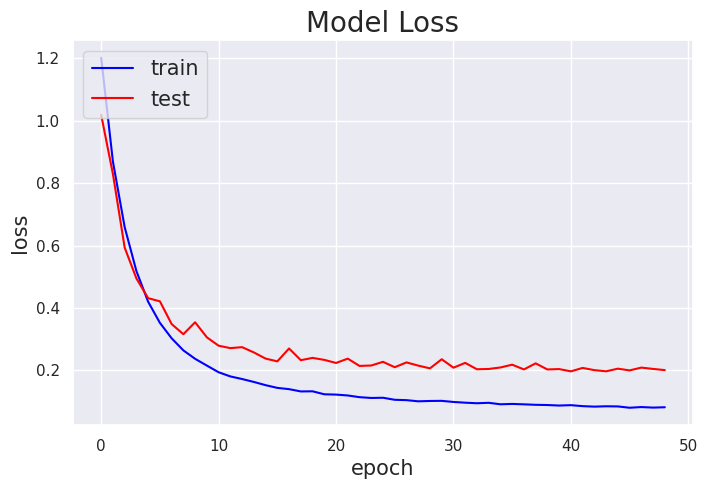

In [25]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

Next we plot the predicted values of the parameters (flux and Sérsic radius) against their actual values.

In [26]:
# Generate predictions on test set
CNN_predictions = CNN_2.predict(X_test)

NameError: ignored

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('True vs. Predicted Values of Flux and Sérsic Radius', fontsize=20)

# Plot true vs. predicted values of flux
im_flux = ax[0].scatter(y_test[:, [0]], CNN_predictions[:, 0], c=[snr[indices_test]])
ax[0].set_title('Flux', fontsize=15)
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [0]]), max(y_test[:, [0]]), 100)
ax[0].plot(x, x)
fig.colorbar(im_flux, ax = ax[0])

# Plot true vs. predicted values of Sérsic radius
im_radius = ax[1].scatter(y_test[:, [2]], CNN_predictions[:, 1], c=[snr[indices_test]])
ax[1].set_title('Sérsic Radius', fontsize=15)
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [2]]), max(y_test[:, [2]]), 100)
ax[1].plot(x, x)
fig.colorbar(im_radius, ax = ax[1]);

In [34]:
# indices_30 = []
# index_30 = 0
# for i in snr: 
#   if i < 31 and i > 29 : 
#     indices_30.append(index_30)
#     index_30 += 1
#   else:
#     index_30 +=1
#     continue

# indices_60 = []
# index_60 = 0
# for i in snr: 
#   if i < 61 and i > 59 : 
#     indices_60.append(index_60)
#     index_60 += 1
#   else:
#     index_60 +=1
#     continue

indices_30 = find_30(snr_v)
indices_60 = find_60(snr_v)

NameError: ignored

In [0]:
images_30 = image_with_noise[indices_30]
labels_30 = labels[indices_30]

images_30 = np.expand_dims(images_30, axis=3)
predictions_30 = CNN.predict(images_30)

snr[indices_30]
images_60 = image_with_noise[indices_60]
labels_60 = labels[indices_60]

images_60 = np.expand_dims(images_60, axis=3)
predictions_60 = CNN.predict(images_60)

errors = predictions_30 - labels_30[:, [0, 2]]
flux_error_30 = errors[:, 0].mean()
radius_error_30 = errors[:, 1].mean()
flux_std_30 = np.std(errors[:, 0])
radius_std_30 = np.std(errors[:, 1])


In [0]:
errors = predictions_30 - labels_30[:, [0, 2]]
flux_error_30 = errors[:, 0].mean()
radius_error_30 = errors[:, 1].mean()
flux_std_30 = np.std(errors[:, 0])
radius_std_30 = np.std(errors[:, 1])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))

errors = predictions_60 - labels_60[:, [0, 2]]
flux_error_60 = errors[:, 0].mean()
radius_error_60 = errors[:, 1].mean()
flux_std_60 = np.std(errors[:, 0])
radius_std_60 = np.std(errors[:, 1])


print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))




Flux error 30: 0.142 +/- 0.08
Sersic Radius error 30: -0.077 +/- 0.08

Flux error 60: 0.285 +/- 0.11
Sersic Radius error 60: -0.092 +/- 0.06


In [0]:
file_path = '/content/drive/My Drive/Data/Target Images (for prediction error)'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

target_with_noise_img_30 = pd.read_pickle('img_with_noise_target_30.pkl')
target_with_noise_img_60 = pd.read_pickle('img_with_noise_target_60.pkl')
target_labels = pd.read_pickle('labels_target.pkl')

target_img_30 = np.expand_dims(target_with_noise_img_30, axis=3)
target_img_60 = np.expand_dims(target_with_noise_img_60, axis=3)

target_predictions_30 = CNN.predict(target_img_30)
target_predictions_60 = CNN.predict(target_img_60)


errors_30 = target_predictions_30 - target_labels[:, [0, 2]]
errors_60 = target_predictions_60 - target_labels[:, [0, 2]]

flux_error_30 = errors_30[:, 0].mean()
radius_error_30 = errors_30[:, 1].mean()
flux_std_30 = np.std(errors_30[:, 0])
radius_std_30 = np.std(errors_30[:, 1])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))


flux_error_60 = errors_60[:, 0].mean()
radius_error_60 = errors_60[:, 1].mean()
flux_std_60 = np.std(errors_60[:, 0])
radius_std_60 = np.std(errors_60[:, 1])

print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))

Working Directory: /content/drive/My Drive/Data/Target Images (for prediction error)
Flux error 30: 0.138 +/- 0.1
Sersic Radius error 30: -0.065 +/- 0.07

Flux error 60: 0.131 +/- 0.06
Sersic Radius error 60: -0.099 +/- 0.04


### CNN #3: Predicting all parameters with noise and PSF fixed

In [18]:
# Set new file path to access generated dataset
file_path = '/content/drive/My Drive/Data/Data_all_fixed_noise'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

# Load generated dataset
image_no_noise_all= pd.read_pickle('img_no_noise_all.pkl')
image_with_noise_all= pd.read_pickle('img_with_noise_all.pkl')
labels_all = pd.read_pickle('labels_all.pkl')
snr_all = pd.read_pickle('snr_all.pkl')

Working Directory: /content/drive/My Drive/Data/Data_all_fixed_noise


In [0]:
# Split data into train and test sets
indices = np.linspace(0, 9999, 10000, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise_all, labels_all, indices, test_size=0.2)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [23]:
# Create model
CNN_all = create_model(5)

# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            verbose=1)]

# Compile model
CNN_all.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       11

In [24]:
# Set hyperparameters
batch_size = 32
epochs = 50

# Train model
history = CNN_all.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
250/250 [==============================] - 40s 162ms/step - loss: 1.7957 - mean_absolute_error: 0.3699 - val_loss: 1.4698 - val_mean_absolute_error: 0.3113
Epoch 2/50
250/250 [==============================] - 41s 162ms/step - loss: 1.2018 - mean_absolute_error: 0.2402 - val_loss: 1.0187 - val_mean_absolute_error: 0.2288
Epoch 3/50
250/250 [==============================] - 42s 169ms/step - loss: 0.8690 - mean_absolute_error: 0.2072 - val_loss: 0.8293 - val_mean_absolute_error: 0.2792
Epoch 4/50
250/250 [==============================] - 42s 166ms/step - loss: 0.6592 - mean_absolute_error: 0.1920 - val_loss: 0.5935 - val_mean_absolute_error: 0.1989
Epoch 5/50
250/250 [==============================] - 42s 168ms/step - loss: 0.5182 - mean_absolute_error: 0.1777 - val_loss: 0.4946 - val_mean_absolute_error: 0.2014
Epoch 6/50
250/250 [==============================] - 42s 167ms/step - loss: 0.4199 - mean_absolute_error: 0.1625 - val_loss: 0.4314 - val_mean_absolute_error: 0.205

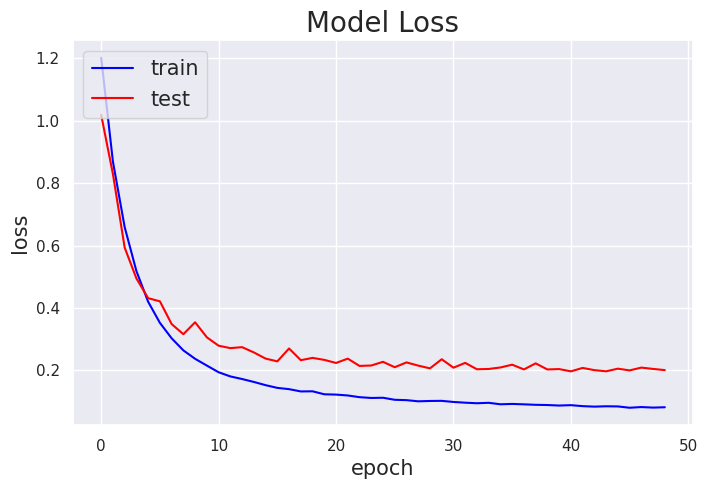

In [27]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

In [0]:
# Generate predictions on test data
CNN_predictions_all = CNN_all.predict(X_test)

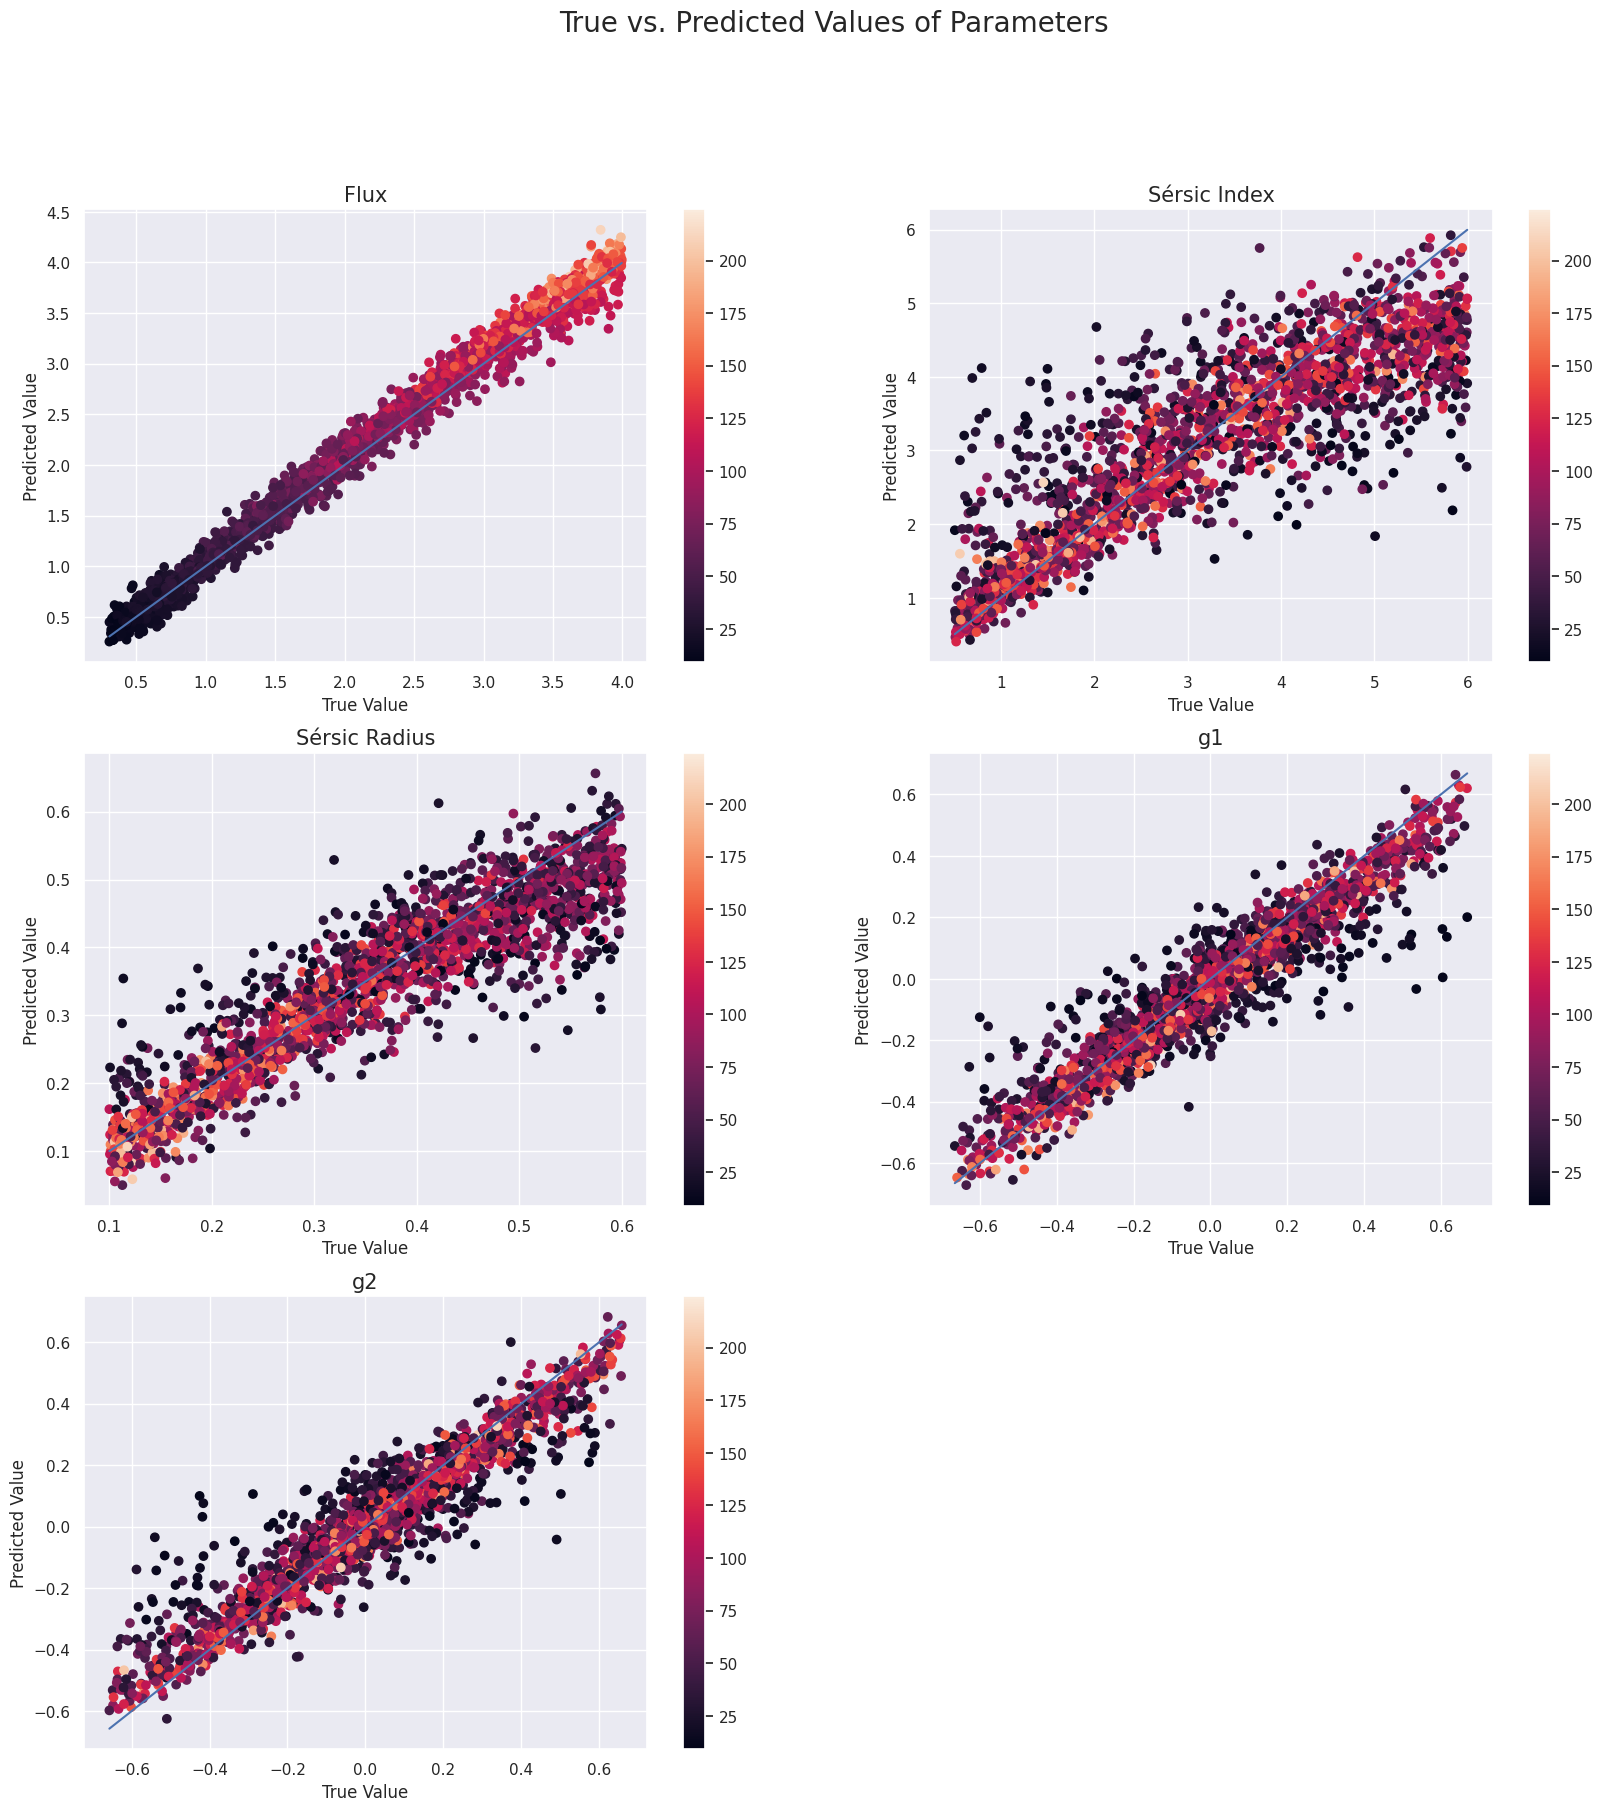

In [29]:
fig, axes = plt.subplots(3,2, figsize=(20,20))
fig.delaxes(axes[2,1])
parameters = ['Flux', 'Sérsic Index', 'Sérsic Radius', 'g1', 'g2']

for i in range(5):

  im_var = axes.flat[i].scatter(y_test[:, i], CNN_predictions_all[:, i], c=[snr_all[indices_test]])
  x = np.linspace(min(y_test[:, [i]]), max(y_test[:, [i]]), 100)
  axes.flat[i].plot(x, x)
  fig.colorbar(im_var, ax=axes.flat[i])

  axes.flat[i].set_xlabel('True Value')
  axes.flat[i].set_ylabel('Predicted Value')
  axes.flat[i].set_title(parameters[i], fontsize=15)

fig.suptitle('True vs. Predicted Values of Parameters', fontsize=20);

In [36]:
indices_30 = find_30(snr_all)
indices_60 = find_60(snr_all)

images_30 = image_with_noise_all[indices_30]
labels_30 = labels_all[indices_30]

images_30 = np.expand_dims(images_30, axis=3)
predictions_30 = CNN_all.predict(images_30)

images_60 = image_with_noise_all[indices_60]
labels_60 = labels_all[indices_60]

images_60 = np.expand_dims(images_60, axis=3)
predictions_60 = CNN_all.predict(images_60)

errors_30 = predictions_30 - labels_30
errors_60 = predictions_60 - labels_60

flux_error_30 = errors_30[:, 0].mean()
index_error_30 = errors_30[:, 1].mean()
radius_error_30 = errors_30[:, 2].mean()
g1_error_30 = errors_30[:, 3].mean()
g2_error_30 = errors_30[:, 4].mean()
flux_std_30 = np.std(errors_30[:, 0])
index_std_30 = np.std(errors_30[:, 1])
radius_std_30 = np.std(errors_30[:, 2])
g1_std_30 = np.std(errors_30[:, 3])
g2_std_30 = np.std(errors_30[:, 4])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Index error 30: %s +/- %s" %(round(index_error_30,3), round(index_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))
print("G1 error 30: %s +/- %s" %(round(g1_error_30,3), round(g1_std_30, 2)))
print("G2 error 30: %s +/- %s" %(round(g2_error_30,3), round(g2_std_30, 2)))


flux_error_60 = errors_60[:, 0].mean()
index_error_60 = errors_60[:, 1].mean()
radius_error_60 = errors_60[:, 2].mean()
g1_error_60 = errors_60[:, 3].mean()
g2_error_60 = errors_60[:, 4].mean()
flux_std_60 = np.std(errors_60[:, 0])
index_std_60 = np.std(errors_60[:, 1])
radius_std_60 = np.std(errors_60[:, 2])
g1_std_60 = np.std(errors_60[:, 3])
g2_std_60 = np.std(errors_60[:, 4])


print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Index error 60: %s +/- %s" %(round(index_error_60,3), round(index_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))
print("G1 error 60: %s +/- %s" %(round(g1_error_60,3), round(g1_std_60, 2)))
print("G2 error 60: %s +/- %s" %(round(g2_error_60,3), round(g2_std_60, 2)))


Flux error 30: 0.016 +/- 0.06
Sersic Index error 30: 0.036 +/- 0.45
Sersic Radius error 30: -0.006 +/- 0.03
G1 error 30: -0.026 +/- 0.06
G2 error 30: -0.0 +/- 0.07

Flux error 60: 0.053 +/- 0.07
Sersic Index error 60: -0.084 +/- 0.5
Sersic Radius error 60: -0.021 +/- 0.03
G1 error 60: -0.017 +/- 0.05
G2 error 60: -0.001 +/- 0.05


In [0]:
file_path = '/content/drive/My Drive/Data/Target Images (for prediction error)'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

target_with_noise_img_30 = pd.read_pickle('img_with_noise_target_30.pkl')
target_with_noise_img_60 = pd.read_pickle('img_with_noise_target_60.pkl')
target_labels = pd.read_pickle('labels_target.pkl')

target_img_30 = np.expand_dims(target_with_noise_img_30, axis=3)
target_img_60 = np.expand_dims(target_with_noise_img_60, axis=3)

target_predictions_30 = CNN_all.predict(target_img_30)
target_predictions_60 = CNN_all.predict(target_img_60)


errors_30 = target_predictions_30 - target_labels
errors_60 = target_predictions_60 - target_labels

flux_error_30 = errors_30[:, 0].mean()
index_error_30 = errors_30[:, 1].mean()
radius_error_30 = errors_30[:, 2].mean()
g1_error_30 = errors_30[:, 3].mean()
g2_error_30 = errors_30[:, 4].mean()
flux_std_30 = np.std(errors_30[:, 0])
index_std_30 = np.std(errors_30[:, 1])
radius_std_30 = np.std(errors_30[:, 2])
g1_std_30 = np.std(errors_30[:, 3])
g2_std_30 = np.std(errors_30[:, 4])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Index error 30: %s +/- %s" %(round(index_error_30,3), round(index_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))
print("G1 error 30: %s +/- %s" %(round(g1_error_30,3), round(g1_std_30, 2)))
print("G2 error 30: %s +/- %s" %(round(g2_error_30,3), round(g2_std_30, 2)))


flux_error_60 = errors_60[:, 0].mean()
index_error_60 = errors_60[:, 1].mean()
radius_error_60 = errors_60[:, 2].mean()
g1_error_60 = errors_60[:, 3].mean()
g2_error_60 = errors_60[:, 4].mean()
flux_std_60 = np.std(errors_60[:, 0])
index_std_60 = np.std(errors_60[:, 1])
radius_std_60 = np.std(errors_60[:, 2])
g1_std_60 = np.std(errors_60[:, 3])
g2_std_60 = np.std(errors_60[:, 4])


print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Index error 60: %s +/- %s" %(round(index_error_60,3), round(index_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))
print("G1 error 60: %s +/- %s" %(round(g1_error_60,3), round(g1_std_60, 2)))
print("G2 error 60: %s +/- %s" %(round(g2_error_60,3), round(g2_std_60, 2)))


Working Directory: /content/drive/My Drive/Data/Target Images (for prediction error)
Flux error 30: 0.021 +/- 0.11
Sersic Index error 30: 0.373 +/- 0.8
Sersic Radius error 30: -0.04 +/- 0.06
G1 error 30: 0.02 +/- 0.12
G2 error 30: -0.034 +/- 0.1

Flux error 60: 0.145 +/- 0.07
Sersic Index error 60: 0.622 +/- 0.55
Sersic Radius error 60: 0.03 +/- 0.03
G1 error 60: -0.003 +/- 0.07
G2 error 60: 0.018 +/- 0.07


### CNN #4: Predicting all parameters using the dataset provided (noise and PSF not fixed)


In [0]:
# Set new file path to access provided dataset
file_path = '/content/drive/My Drive/Data'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

# Load provided dataset
f=h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # Parameters
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

Working Directory: /content/drive/My Drive/Data


In [0]:
# Split data into train and test sets
indices = np.linspace(0, 18778, 18779, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_withnoise, label, indices, test_size=0.2)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [0]:
# Create model
CNN_all_provided = create_model(5)

# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            verbose=1)]

# Compile model
CNN_all_provided.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       11

In [0]:
# Set hyperparameters
batch_size = 32
epochs = 50

# Train model
history = CNN_all_provided.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
470/470 [==============================] - 75s 159ms/step - loss: 1.6848 - mean_absolute_error: 0.4146 - val_loss: 1.1963 - val_mean_absolute_error: 0.3197
Epoch 2/50
470/470 [==============================] - 74s 158ms/step - loss: 0.9452 - mean_absolute_error: 0.3104 - val_loss: 0.7450 - val_mean_absolute_error: 0.2973
Epoch 3/50
470/470 [==============================] - 75s 160ms/step - loss: 0.6279 - mean_absolute_error: 0.2887 - val_loss: 0.5433 - val_mean_absolute_error: 0.2879
Epoch 4/50
470/470 [==============================] - 75s 159ms/step - loss: 0.4784 - mean_absolute_error: 0.2728 - val_loss: 0.5130 - val_mean_absolute_error: 0.3469
Epoch 5/50
470/470 [==============================] - 75s 160ms/step - loss: 0.3916 - mean_absolute_error: 0.2508 - val_loss: 0.4211 - val_mean_absolute_error: 0.3014
Epoch 6/50
470/470 [==============================] - 75s 160ms/step - loss: 0.3320 - mean_absolute_error: 0.2269 - val_loss: 0.3871 - val_mean_absolute_error: 0.294

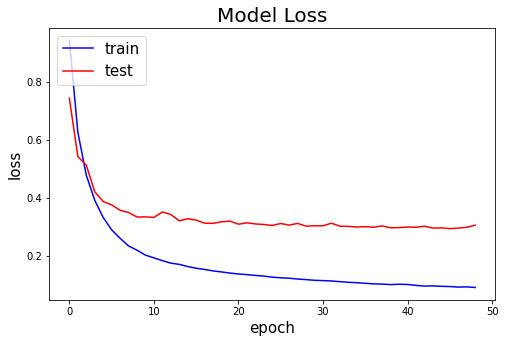

In [0]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

In [0]:
# Generate predictions on test data
CNN_predictions_all = CNN_all_provided.predict(X_test)

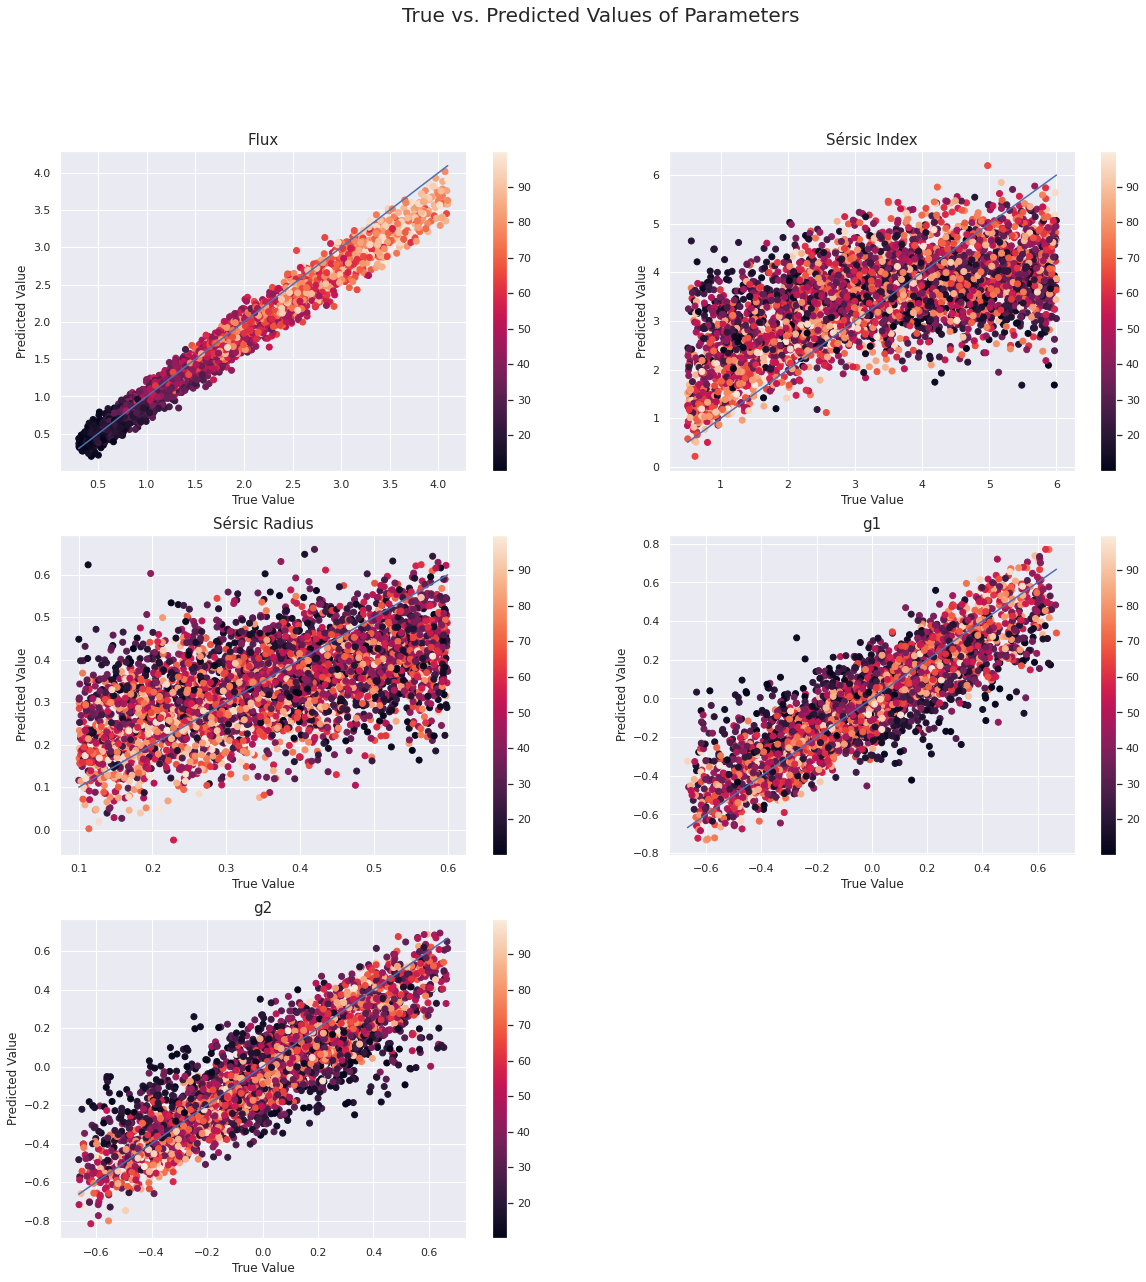

In [0]:
# Plot true vs. predicted values of each of the parameters
fig, axes = plt.subplots(3,2, figsize=(20,20))
fig.delaxes(axes[2,1])
parameters = ['Flux', 'Sérsic Index', 'Sérsic Radius', 'g1', 'g2']

for i in range(5):

  im_var = axes.flat[i].scatter(y_test[:, i], CNN_predictions_all[:, i], c=[snr[indices_test]])
  x = np.linspace(min(y_test[:, [i]]), max(y_test[:, [i]]), 100)
  axes.flat[i].plot(x, x)
  fig.colorbar(im_var, ax=axes.flat[i])

  axes.flat[i].set_xlabel('True Value')
  axes.flat[i].set_ylabel('Predicted Value')
  axes.flat[i].set_title(parameters[i], fontsize=15)

fig.suptitle('True vs. Predicted Values of Parameters', fontsize=20);

In [0]:
file_path = '/content/drive/My Drive/Data/Target Images (for prediction error)'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

target_with_noise_img_30 = pd.read_pickle('img_with_noise_target_30.pkl')
target_with_noise_img_60 = pd.read_pickle('img_with_noise_target_60.pkl')
target_labels = pd.read_pickle('labels_target.pkl')

target_img_30 = np.expand_dims(target_with_noise_img_30, axis=3)
target_img_60 = np.expand_dims(target_with_noise_img_60, axis=3)

target_predictions_30 = CNN_all.predict(target_img_30)
target_predictions_60 = CNN_all.predict(target_img_60)


errors_30 = target_predictions_30 - target_labels
errors_60 = target_predictions_60 - target_labels

flux_error_30 = errors_30[:, 0].mean()
index_error_30 = errors_30[:, 1].mean()
radius_error_30 = errors_30[:, 2].mean()
g1_error_30 = errors_30[:, 3].mean()
g2_error_30 = errors_30[:, 4].mean()
flux_std_30 = np.std(errors_30[:, 0])
index_std_30 = np.std(errors_30[:, 1])
radius_std_30 = np.std(errors_30[:, 2])
g1_std_30 = np.std(errors_30[:, 3])
g2_std_30 = np.std(errors_30[:, 4])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Index error 30: %s +/- %s" %(round(index_error_30,3), round(index_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))
print("G1 error 30: %s +/- %s" %(round(g1_error_30,3), round(g1_std_30, 2)))
print("G2 error 30: %s +/- %s" %(round(g2_error_30,3), round(g2_std_30, 2)))


flux_error_60 = errors_60[:, 0].mean()
index_error_60 = errors_60[:, 1].mean()
radius_error_60 = errors_60[:, 2].mean()
g1_error_60 = errors_60[:, 3].mean()
g2_error_60 = errors_60[:, 4].mean()
flux_std_60 = np.std(errors_60[:, 0])
index_std_60 = np.std(errors_60[:, 1])
radius_std_60 = np.std(errors_60[:, 2])
g1_std_60 = np.std(errors_60[:, 3])
g2_std_60 = np.std(errors_60[:, 4])


print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Index error 60: %s +/- %s" %(round(index_error_60,3), round(index_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))
print("G1 error 60: %s +/- %s" %(round(g1_error_60,3), round(g1_std_60, 2)))
print("G2 error 60: %s +/- %s" %(round(g2_error_60,3), round(g2_std_60, 2)))

Working Directory: /content/drive/My Drive/Data/Target Images (for prediction error)
Flux error 30: 0.066 +/- 0.11
Sersic Index error 30: 0.875 +/- 0.65
Sersic Radius error 30: -0.051 +/- 0.08
G1 error 30: 0.007 +/- 0.14
G2 error 30: 0.022 +/- 0.12

Flux error 60: 0.047 +/- 0.07
Sersic Index error 60: 0.841 +/- 0.61
Sersic Radius error 60: -0.067 +/- 0.06
G1 error 60: -0.024 +/- 0.1
G2 error 60: 0.051 +/- 0.09


|  Parameter |  Two labels, fixed noise/psf SNR 30 | Two labels, Variable Noise/PSF SNR 30|
| -------:| ----:  | ----:  |
|Flux (1)| -0.039+/- 0.09|0.138 +/- 0.1|
|Sersic Index (3) | N/A | N/A|
|Sersic Radius (0.3)|-0.025 +/- 0.05| -0.065 +/- 0.07|
|G1 (-0.069)|N/A|N/A|
|G2 (0.15)|N/A|N/A|



|  Parameter |  Two labels, fixed noise/psf SNR 60 | Two labels, Variable Noise/PSF SNR 60|
| -------:| ----:  | ----:  |
|Flux (1)| 0.042 +/- 0.05|0.131 +/- 0.06|
|Sersic Index (3) | N/A | N/A|
|Sersic Radius (0.3)|0.009 +/- 0.03| -0.099 +/- 0.04|
|G1 (-0.069)|N/A|N/A|
|G2 (0.15)|N/A|N/A|
